Found 30 .obj files
Processing 00156.obj...
Processing 00180.obj...
Processing 00169.obj...
Processing 00168.obj...
Processing 00154.obj...
Processing 00187.obj...
Processing 00151.obj...
Processing 00179.obj...
Processing 00190.obj...
Processing 00147.obj...
Processing 00152.obj...
Processing 00185.obj...
Processing 00191.obj...
Processing 00135.obj...
Processing 00134.obj...
Processing 00122.obj...
Processing 00136.obj...
Processing 00137.obj...
Processing 00127.obj...
Processing 00129.obj...
Processing 00188.obj...
Processing 00163.obj...
Processing 00176.obj...
Processing 00160.obj...
Processing 00174.obj...
Processing 00148.obj...
Processing 00149.obj...
Processing 00175.obj...
Processing 00170.obj...
Processing 00167.obj...
Plot saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/height_vs_whr_plot.png
Measurements saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv


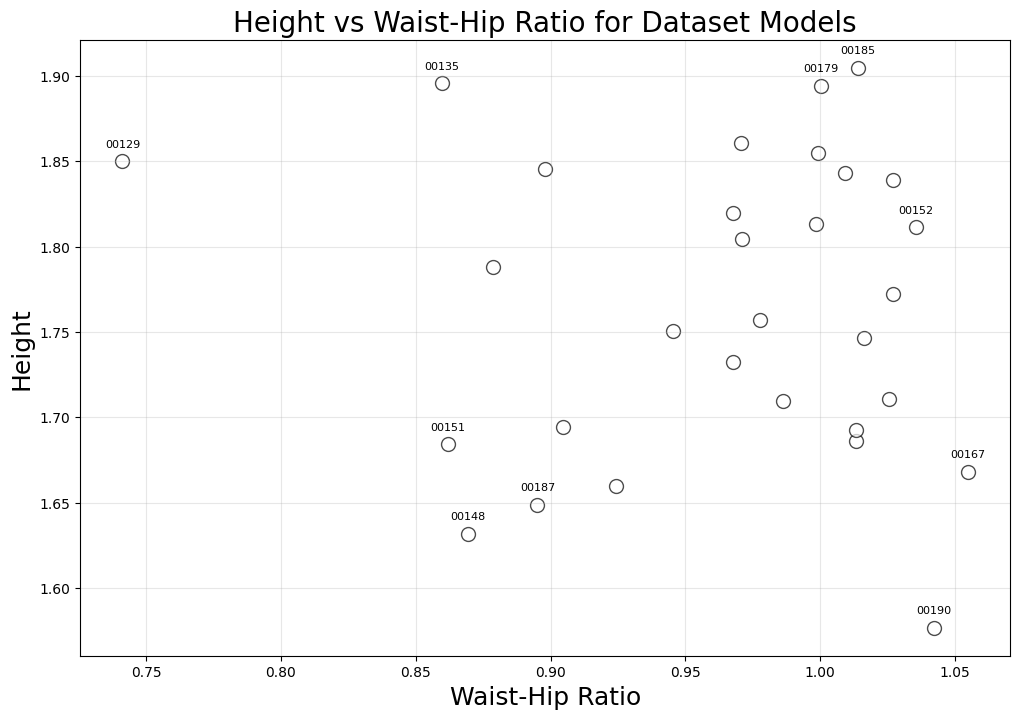

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import trimesh
from scipy.spatial import ConvexHull
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

def calculate_body_measurements(obj_file):
    """
    Calculate height and waist-hip ratio for a 3D model
    
    Args:
        obj_file: Path to the .obj file
        
    Returns:
        tuple: (height, waist_hip_ratio, waist_circumference, hip_circumference)
    """
    try:
        # Load the mesh
        mesh = trimesh.load_mesh(obj_file)
        
        # Extract vertices
        vertices = np.array(mesh.vertices)
        
        # Calculate height (max y - min y)
        height = vertices[:, 1].max() - vertices[:, 1].min()
        
        # Determine vertical range for analysis
        y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
        
        # Define regions for waist and hip calculations
        # Waist is generally around 35-45% of height from bottom
        # Hip is generally around 25-35% of height from bottom
        waist_region_min = y_min + height * 0.35
        waist_region_max = y_min + height * 0.6
        hip_region_min = y_min + height * 0.25
        hip_region_max = y_min + height * 0.35
        
        # Calculate waist (minimum circumference in the waist region)
        waist_circumference = float('inf')
        waist_y = None
        
        # Calculate hip (maximum circumference in the hip region)
        hip_circumference = 0
        hip_y = None
        
        # Check horizontal slices at different heights
        num_slices = 50
        y_values = np.linspace(y_min, y_max, num_slices)
        
        for y in y_values:
            # Find vertices close to this horizontal slice (within a small tolerance)
            tolerance = height / 100  # 1% of height
            slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
            
            if len(slice_indices) < 3:
                continue  # Need at least 3 points for a valid slice
            
            # Project points to XZ plane
            slice_points = vertices[slice_indices][:, [0, 2]]  # Extract X and Z coordinates
            
            # Calculate circumference using the convex hull
            try:
                hull = ConvexHull(slice_points)
                circumference = hull.area
                
                # Check if this is in the waist region
                if waist_region_min <= y <= waist_region_max and circumference < waist_circumference:
                    waist_circumference = circumference
                    waist_y = y
                
                # Check if this is in the hip region
                if hip_region_min <= y <= hip_region_max and circumference > hip_circumference:
                    hip_circumference = circumference
                    hip_y = y
            except:
                # Skip if convex hull calculation fails
                continue
        
        # If waist or hip wasn't found in the expected regions, use best estimate
        if waist_circumference == float('inf'):
            # Find minimum circumference in the middle area of the model
            for y in y_values:
                if y_min + height * 0.3 <= y <= y_min + height * 0.7:  # Middle area
                    slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
                    if len(slice_indices) < 3:
                        continue
                    slice_points = vertices[slice_indices][:, [0, 2]]
                    try:
                        hull = ConvexHull(slice_points)
                        if hull.area < waist_circumference:
                            waist_circumference = hull.area
                    except:
                        continue
        
        if hip_circumference == 0:
            # Find maximum circumference in the lower area of the model
            for y in y_values:
                if y_min + height * 0.2 <= y <= y_min + height * 0.4:  # Lower area
                    slice_indices = np.where(np.abs(vertices[:, 1] - y) < tolerance)[0]
                    if len(slice_indices) < 3:
                        continue
                    slice_points = vertices[slice_indices][:, [0, 2]]
                    try:
                        hull = ConvexHull(slice_points)
                        if hull.area > hip_circumference:
                            hip_circumference = hull.area
                    except:
                        continue
        
        # Prevent division by zero
        if hip_circumference == 0:
            return height, None, waist_circumference, hip_circumference
        
        # Calculate waist-hip ratio
        waist_hip_ratio = waist_circumference / hip_circumference
        
        return height, waist_hip_ratio, waist_circumference, hip_circumference
    
    except Exception as e:
        print(f"Error processing {os.path.basename(obj_file)}: {str(e)}")
        return None, None, None, None

def visualize_body_dimensions(data_dir):
    """
    Create a scatter plot of height vs waist-hip ratio for all models in the directory
    
    Args:
        data_dir: Directory containing .obj files
    """
    # Find all .obj files
    obj_files = glob.glob(os.path.join(data_dir, "*.obj"))
    print(f"Found {len(obj_files)} .obj files")
    
    # Process each file
    results = []
    
    for obj_file in obj_files:
        print(f"Processing {os.path.basename(obj_file)}...")
        height, whr, waist, hip = calculate_body_measurements(obj_file)
        
        if height is not None and whr is not None:
            results.append({
                'filename': os.path.basename(obj_file),
                'height': height,
                'waist_hip_ratio': whr,
                'waist': waist,
                'hip': hip
            })
    
    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(results)
    
    if df.empty:
        print("No valid measurements found.")
        return
    
    # # Create custom colormap
    # colors = ['#00DDFF', '#EEFF00', '#FF0000']
    # cmap_name = 'custom_cmap'
    # cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    
    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        df['waist_hip_ratio'], 
        df['height'], 
        c='white',  # Color by waist-hip ratio
        # cmap=cm,
        alpha=0.7,
        s=100,  # Point size
        edgecolors='black'
    )
    
    # # Add colorbar
    # cbar = plt.colorbar(scatter)
    # cbar.set_label('Waist-Hip Ratio', fontsize=12)
    
    # Add labels and title
    plt.xlabel('Waist-Hip Ratio', fontsize=18)
    plt.ylabel('Height', fontsize=18)
    plt.title('Height vs Waist-Hip Ratio for Dataset Models', fontsize=20)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add annotations for outliers or interesting points
    for _, row in df.iterrows():
        if row['waist_hip_ratio'] > np.percentile(df['waist_hip_ratio'], 90) or \
           row['waist_hip_ratio'] < np.percentile(df['waist_hip_ratio'], 10) or \
           row['height'] > np.percentile(df['height'], 90) or \
           row['height'] < np.percentile(df['height'], 10):
            plt.annotate(row['filename'][:-4], 
                        (row['waist_hip_ratio'], row['height']),
                        textcoords="offset points",
                        xytext=(0,10),
                        ha='center',
                        fontsize=8)
    
    # Save plot
    output_dir = os.path.join(os.path.dirname(data_dir), "code/visuals")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, "height_vs_whr_plot.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    # Also save the measurements as CSV
    csv_path = os.path.join(output_dir, "body_measurements.csv")
    df.to_csv(csv_path, index=False)
    
    print(f"Plot saved to {output_path}")
    print(f"Measurements saved to {csv_path}")
    
    plt.show()

if __name__ == "__main__":
    data_directory = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/inner"
    visualize_body_dimensions(data_directory)

Distribution of models by waist-hip ratio (0.05 increments):
  0.7-0.75: 1 models
  0.75-0.8: 0 models
  0.8-0.85: 0 models
  0.85-0.9: 6 models
  0.9-0.95: 3 models
  0.95-1.0: 8 models
  1.0-1.05: 11 models
  1.05-1.1: 1 models


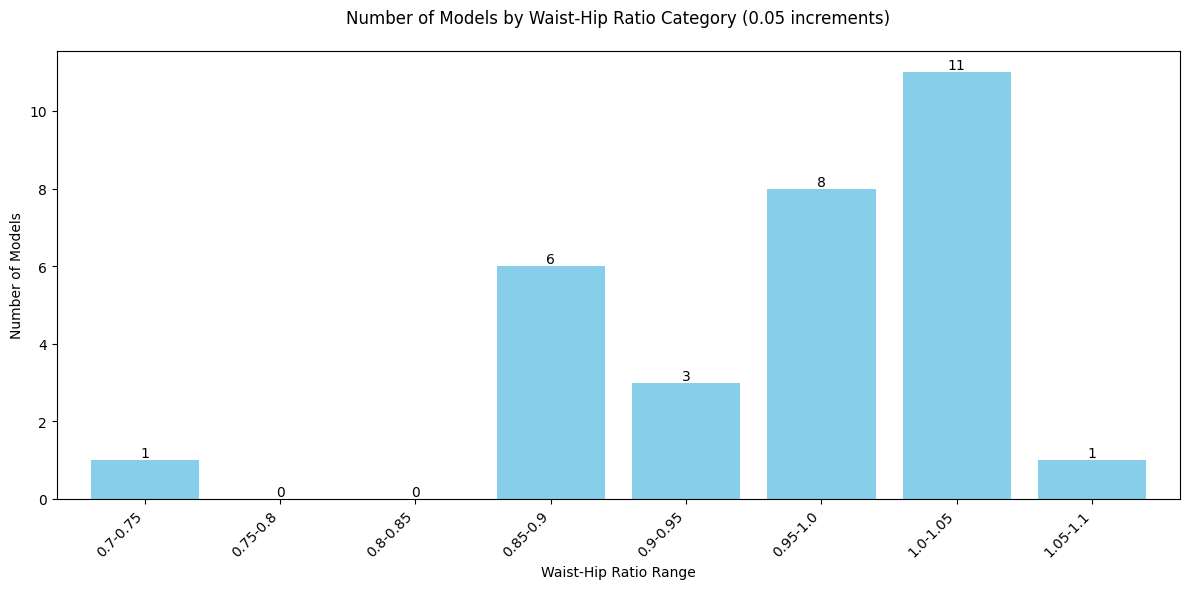

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the body measurements data
body_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv"
body_df = pd.read_csv(body_data_path)

# Create bins for waist-hip ratio in 0.05 increments
bins = np.arange(0.70, 1.15, 0.05)  # Adjusted range based on your data
labels = [f"{round(bins[i], 2)}-{round(bins[i+1], 2)}" for i in range(len(bins)-1)]

# Categorize models into bins
body_df['whr_category'] = pd.cut(body_df['waist_hip_ratio'], bins=bins, labels=labels, right=False)

# Count models in each category
category_counts = body_df['whr_category'].value_counts().sort_index()

# Display results
print("Distribution of models by waist-hip ratio (0.05 increments):")
for category, count in category_counts.items():
    print(f"  {category}: {count} models")

# Create a bar chart with improved formatting
plt.figure(figsize=(12, 6))
ax = category_counts.plot(kind='bar', color='skyblue', width=0.8)
plt.title('Number of Models by Waist-Hip Ratio Category (0.05 increments)', pad=20)
plt.xlabel('Waist-Hip Ratio Range')
plt.ylabel('Number of Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(category_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


Distribution of models by height (0.05m increments):
  1.55-1.6m: 1 models
  1.6-1.65m: 2 models
  1.65-1.7m: 6 models
  1.7-1.75m: 4 models
  1.75-1.8m: 4 models
  1.8-1.85m: 8 models
  1.85-1.9m: 4 models


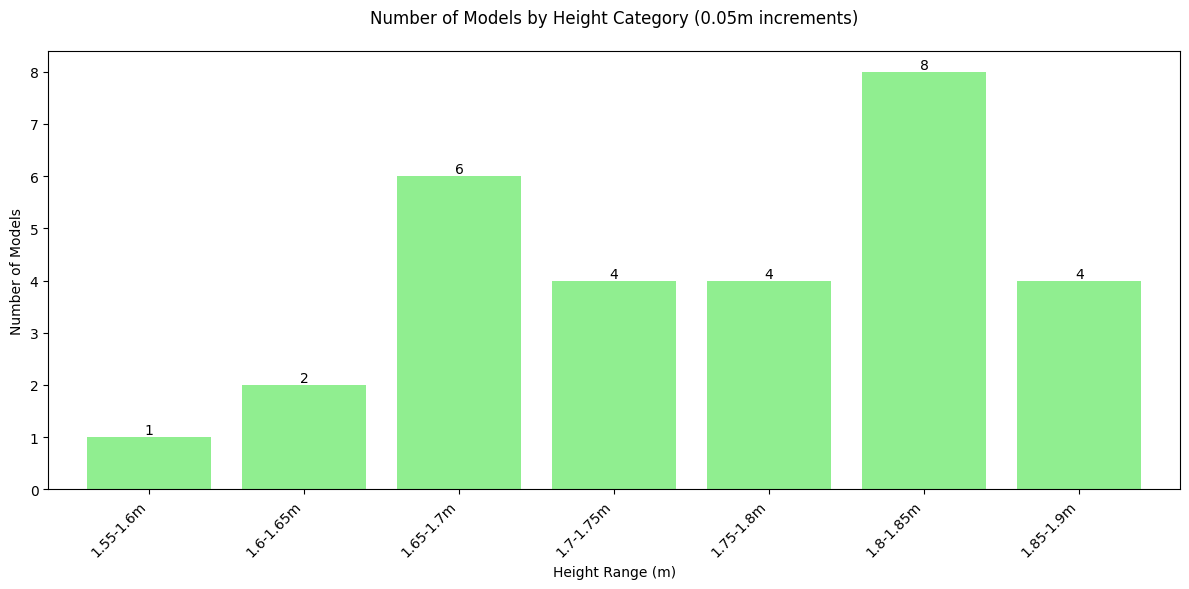


Height Statistics:
Mean height: 1.76m
Median height: 1.76m
Min height: 1.58m
Max height: 1.90m


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the body measurements data
body_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv"
body_df = pd.read_csv(body_data_path)

# Create bins for height in 0.05m increments
height_bins = np.arange(1.55, 1.95, 0.05)  # Adjust range based on your data
height_labels = [f"{round(height_bins[i], 2)}-{round(height_bins[i+1], 2)}m" for i in range(len(height_bins)-1)]

# Categorize models into height bins
body_df['height_category'] = pd.cut(body_df['height'], bins=height_bins, labels=height_labels, right=False)

# Count models in each height category
height_counts = body_df['height_category'].value_counts().sort_index()

# Display results
print("\nDistribution of models by height (0.05m increments):")
for category, count in height_counts.items():
    print(f"  {category}: {count} models")

# Create a bar chart for height distribution
plt.figure(figsize=(12, 6))
ax = height_counts.plot(kind='bar', color='lightgreen', width=0.8)
plt.title('Number of Models by Height Category (0.05m increments)', pad=20)
plt.xlabel('Height Range (m)')
plt.ylabel('Number of Models')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(height_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nHeight Statistics:")
print(f"Mean height: {body_df['height'].mean():.2f}m")
print(f"Median height: {body_df['height'].median():.2f}m")
print(f"Min height: {body_df['height'].min():.2f}m")
print(f"Max height: {body_df['height'].max():.2f}m")

Found 11 missing values. Filling with column means.
Variance explained by PC1: 56.40%
Variance explained by PC2: 15.82%
Total variance explained: 72.22%
PCA plot saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/pca_model_measurements.png


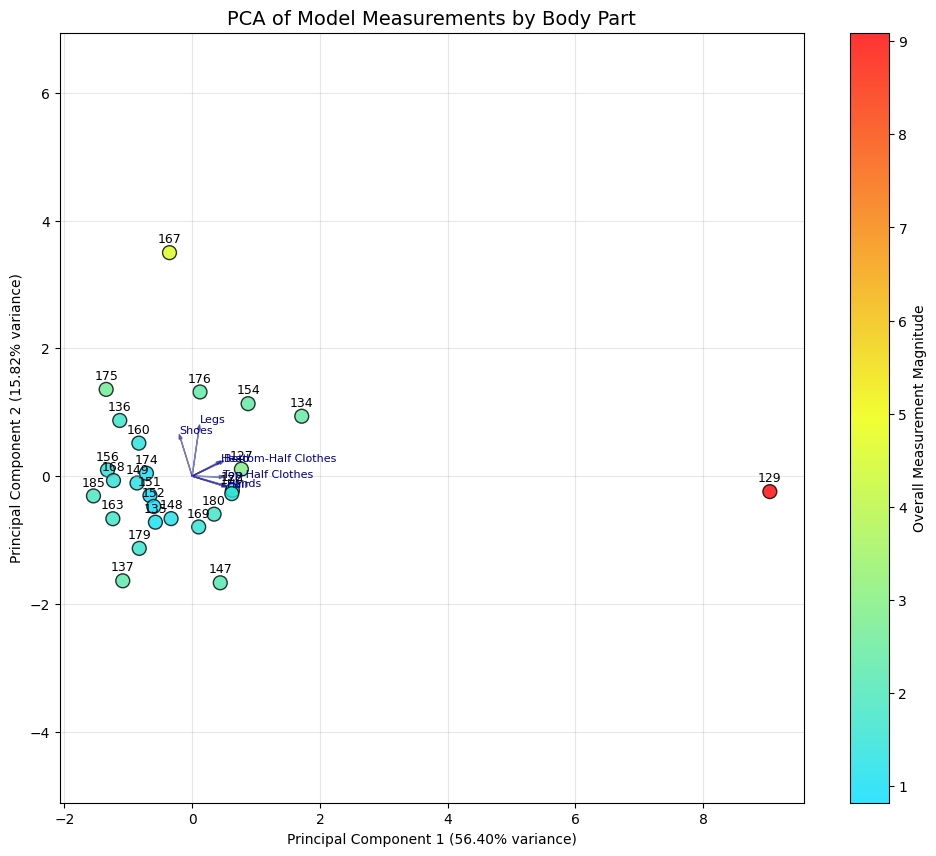

Correlation heatmap saved to: /Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/body_part_correlations.png


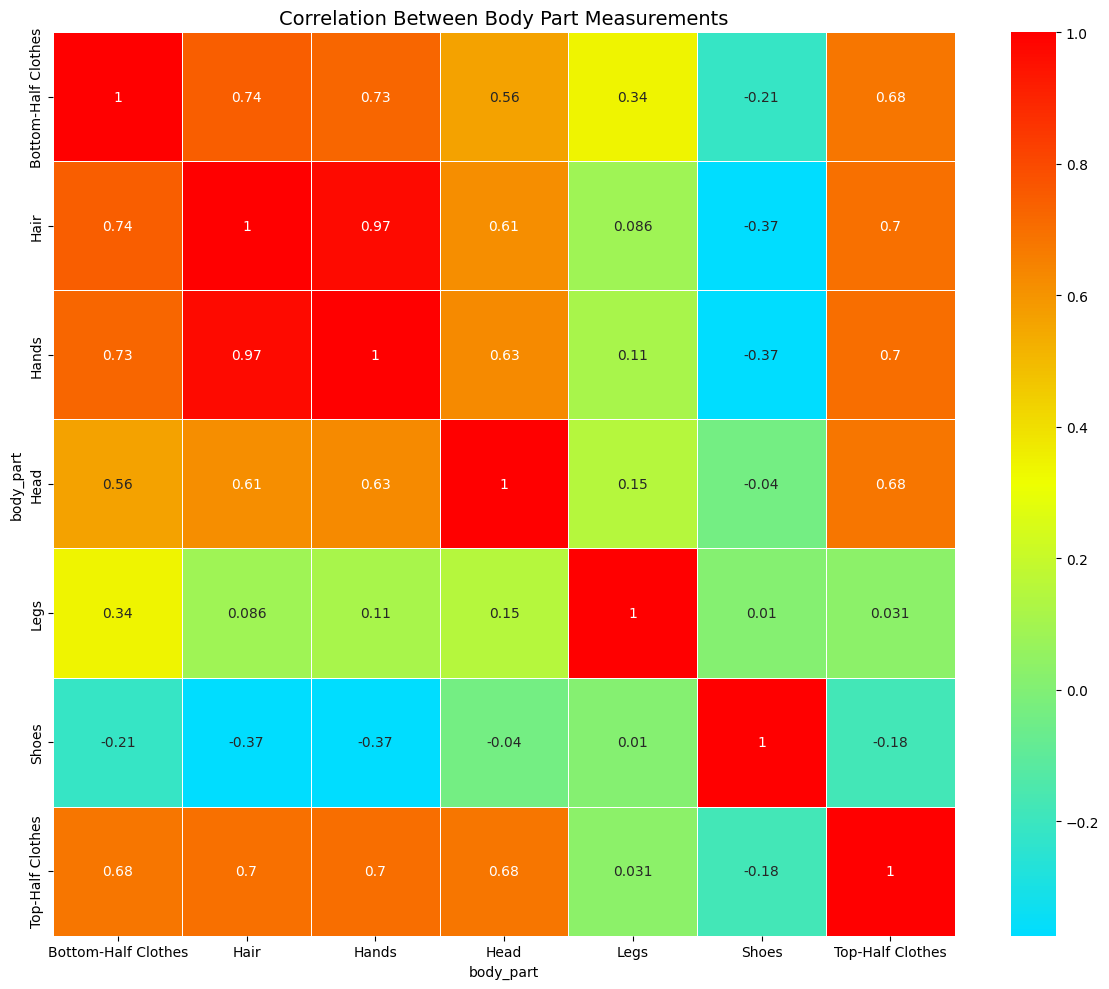

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

# Load the detailed measurements data
data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_labelled_files/analysis_results/detailed_distance_measurements.csv"
df = pd.read_csv(data_path)

# Filter out the 'overall' rows since we want per-body-part measurements
df_filtered = df[df['body_part'] != 'overall']

# Create a pivot table with models as rows and body parts as columns
# We'll use the mean values as our features
pivot_df = df_filtered.pivot_table(
    index='model_id',
    columns='body_part',
    values='mean'
)

# Check for any missing values and fill them if needed
if pivot_df.isna().any().any():
    print(f"Found {pivot_df.isna().sum().sum()} missing values. Filling with column means.")
    pivot_df = pivot_df.fillna(pivot_df.mean())

# Standardize the data (important for PCA)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)

# Apply PCA
n_components = 2  # We'll use 2 for visualization
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(
    data=pca_result,
    columns=['PC1', 'PC2'],
    index=pivot_df.index
)

# Calculate the variance explained by each component
explained_variance = pca.explained_variance_ratio_
print(f"Variance explained by PC1: {explained_variance[0]:.2%}")
print(f"Variance explained by PC2: {explained_variance[1]:.2%}")
print(f"Total variance explained: {sum(explained_variance):.2%}")

# Create custom colormap
colors = ['#00DDFF', '#EEFF00', '#FF0000']
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Visualize the results using a scatter plot
plt.figure(figsize=(12, 10))

# Create the scatter plot
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'],
    c=np.linalg.norm(scaled_data, axis=1),  # Color by overall magnitude of measurements
    cmap=cm,
    alpha=0.8,
    s=100,
    edgecolors='black'
)

# Add labels for each point
for model_id in pca_df.index:
    plt.annotate(
        model_id,
        (pca_df.loc[model_id, 'PC1'], pca_df.loc[model_id, 'PC2']),
        fontsize=9,
        ha='center',
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

# Plot the feature loadings (contribution of each original variable to PCs)
feature_names = pivot_df.columns
loadings = pca.components_.T
max_arrow_length = 1.0  # Scaling factor for arrows

for i, feature in enumerate(feature_names):
    plt.arrow(
        0, 0,  # Start at origin
        loadings[i, 0] * max_arrow_length,  # PC1 loading
        loadings[i, 1] * max_arrow_length,  # PC2 loading
        color='darkblue',
        alpha=0.5,
        head_width=0.05
    )
    plt.text(
        loadings[i, 0] * max_arrow_length * 1.15,
        loadings[i, 1] * max_arrow_length * 1.15,
        feature,
        color='darkblue',
        fontsize=8
    )

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Overall Measurement Magnitude')

# Add labels and title
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%} variance)')
plt.title('PCA of Model Measurements by Body Part', fontsize=14)

# Add a grid
plt.grid(True, alpha=0.3)

# Add an equal aspect ratio for better visualization
plt.axis('equal')

# Save the plot
output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/pca_model_measurements.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"PCA plot saved to: {output_path}")
plt.show()

# Bonus: Create a heatmap showing the correlation between body parts
plt.figure(figsize=(12, 10))
correlation_matrix = pivot_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap=cm, linewidths=0.5)
plt.title('Correlation Between Body Part Measurements', fontsize=14)
plt.tight_layout()

# Save the correlation heatmap
corr_output_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/code/visuals/body_part_correlations.png"
plt.savefig(corr_output_path, dpi=300, bbox_inches='tight')

print(f"Correlation heatmap saved to: {corr_output_path}")
plt.show()

Successfully merged 30 models
Correlation between waist-hip ratio and mean distance: -0.026
Correlation between height and mean distance: 0.051
Plot saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/height_vs_whr_with_distance.png


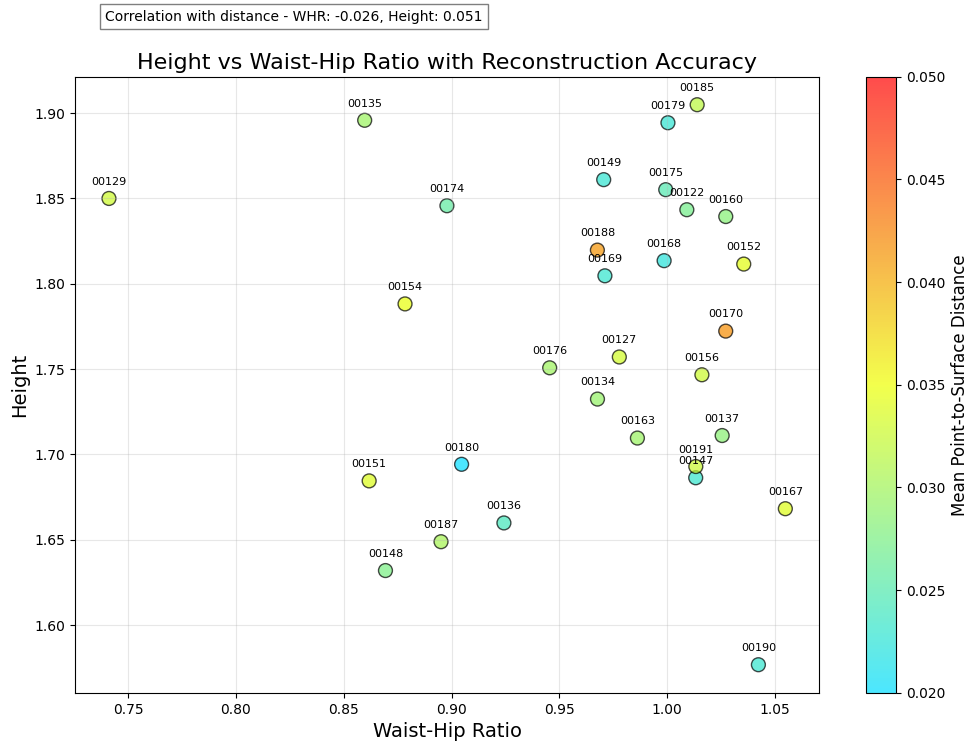

In [18]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load the body measurements data
body_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements.csv"
body_df = pd.read_csv(body_data_path)

# Load the distance measurements data
distance_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_labelled_files/analysis_results/detailed_distance_measurements.csv"
distance_df = pd.read_csv(distance_data_path)

# Filter for overall measurements
overall_df = distance_df[distance_df['body_part'] == 'overall'].copy()

# Extract numeric model_id from both datasets
body_df['numeric_id'] = body_df['filename'].str.extract('(\d+)').astype(int)
overall_df['numeric_id'] = overall_df['model_id'].astype(int)

# Merge datasets using numeric_id
merged_df = pd.merge(body_df, overall_df, on='numeric_id', how='inner')
print(f"Successfully merged {len(merged_df)} models")

# Create custom colormap for distances
colors = ['#00DDFF', '#EEFF00', '#FF0000']  # Blue to yellow to red
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df['waist_hip_ratio'], 
    merged_df['height'], 
    c=merged_df['mean'],  # Coloring by point-to-surface distance
    cmap=cm,
    alpha=0.7,
    s=100,  # Point size
    edgecolors='black',
    vmin=0.02,  # Set minimum of color scale
    vmax=0.05   # Set maximum of color scale
)

# Add colorbar with the same range
cbar = plt.colorbar(scatter)
cbar.set_label('Mean Point-to-Surface Distance', fontsize=12)

# Add labels and title
plt.xlabel('Waist-Hip Ratio', fontsize=14)
plt.ylabel('Height', fontsize=14)
plt.title('Height vs Waist-Hip Ratio with Reconstruction Accuracy', fontsize=16)

# Add grid
plt.grid(True, alpha=0.3)

# Add annotations for all points
for _, row in merged_df.iterrows():
    model_id = row['filename'].split('.')[0]
    plt.annotate(model_id, 
                (row['waist_hip_ratio'], row['height']),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=8)

# Calculate correlation between body measurements and mean distance
corr_whr_dist = merged_df['waist_hip_ratio'].corr(merged_df['mean'])
corr_height_dist = merged_df['height'].corr(merged_df['mean'])
print(f"Correlation between waist-hip ratio and mean distance: {corr_whr_dist:.3f}")
print(f"Correlation between height and mean distance: {corr_height_dist:.3f}")

# Add trend line to show relationship between waist-hip ratio and distance
if len(merged_df) >= 2:
    # Add a small text with correlation values
    plt.figtext(0.15, 0.95, f"Correlation with distance - WHR: {corr_whr_dist:.3f}, Height: {corr_height_dist:.3f}", 
                fontsize=10, ha='left', bbox=dict(facecolor='white', alpha=0.5))

# Save plot
output_dir = os.path.dirname(os.path.dirname(body_data_path))
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "height_vs_whr_with_distance.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Plot saved to {output_path}")
plt.show()

Successfully merged 30 models
Pearson correlation between waist-hip ratio and mean distance: -0.582
Pearson correlation between height and mean distance: 0.154
Spearman correlation between waist-hip ratio and mean distance: -0.361
Spearman correlation between height and mean distance: 0.000
Plot saved to /Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/height_vs_whr_with_distance.png


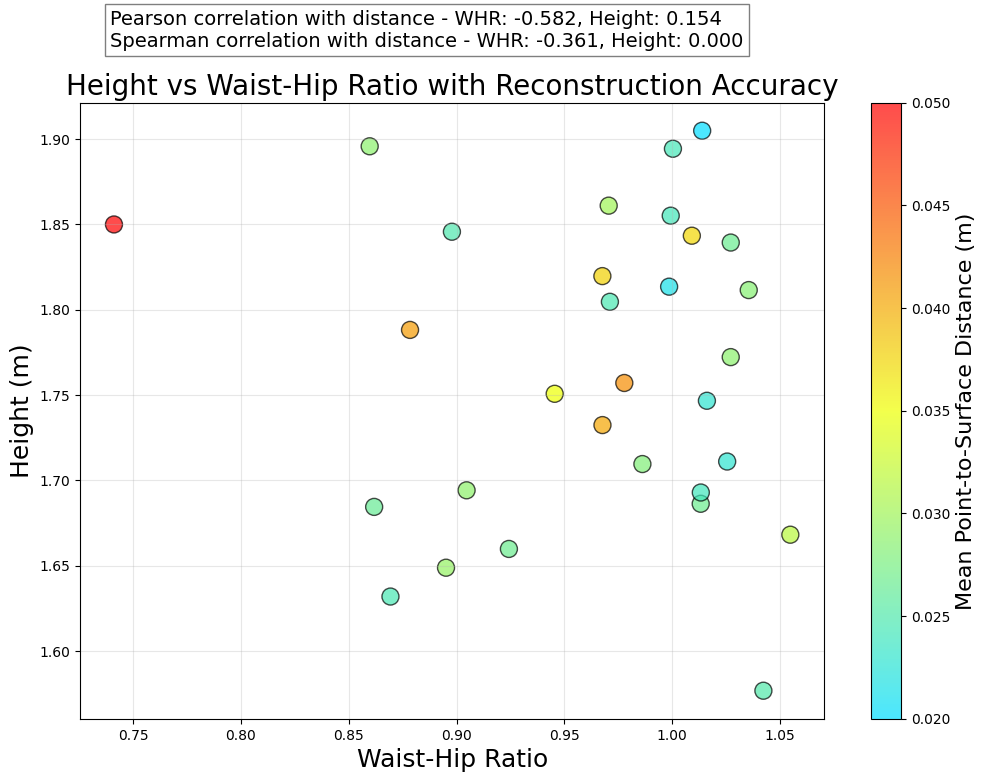

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Load the body measurements data
body_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_files/code/visuals/body_measurements_inner.csv"
body_df = pd.read_csv(body_data_path)

# Load the distance measurements data
distance_data_path = "/Users/paulinagerchuk/Downloads/dataset-segment-analyse/obj_4ddress_labelled_files/analysis_results/detailed_distance_measurements_inner.csv"
distance_df = pd.read_csv(distance_data_path)

# Filter for overall measurements
overall_df = distance_df[distance_df['body_part'] == 'overall'].copy()

# Extract numeric model_id from both datasets
body_df['numeric_id'] = body_df['filename'].str.extract('(\d+)').astype(int)
overall_df['numeric_id'] = overall_df['model_id'].astype(int)

# Merge datasets using numeric_id
merged_df = pd.merge(body_df, overall_df, on='numeric_id', how='inner')
print(f"Successfully merged {len(merged_df)} models")

# Create custom colormap for distances
colors = ['#00DDFF', '#EEFF00', '#FF0000']  # Blue to yellow to red
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

# Create scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    merged_df['waist_hip_ratio'], 
    merged_df['height'], 
    c=merged_df['mean'],  # Coloring by point-to-surface distance
    cmap=cm,
    alpha=0.7,
    s=150,  # Point size
    edgecolors='black',
    vmin=0.02,  # Set minimum of color scale
    vmax=0.05   # Set maximum of color scale
)

# Add colorbar with the same range
cbar = plt.colorbar(scatter)
cbar.set_label('Mean Point-to-Surface Distance (m)', fontsize=16)

# Add labels and title
plt.xlabel('Waist-Hip Ratio', fontsize=18)
plt.ylabel('Height (m)', fontsize=18)
plt.title('Height vs Waist-Hip Ratio with Reconstruction Accuracy', fontsize=20)

# Add grid
plt.grid(True, alpha=0.3)

# Add annotations for all points
# for _, row in merged_df.iterrows():
#     model_id = row['filename'].split('.')[0]
#     plt.annotate(model_id, 
#                 (row['waist_hip_ratio'], row['height']),
#                 textcoords="offset points",
#                 xytext=(0,10),
#                 ha='center',
#                 fontsize=10)

# Calculate Pearson correlation (what you already have)
corr_whr_dist = merged_df['waist_hip_ratio'].corr(merged_df['mean'])
corr_height_dist = merged_df['height'].corr(merged_df['mean'])
print(f"Pearson correlation between waist-hip ratio and mean distance: {corr_whr_dist:.3f}")
print(f"Pearson correlation between height and mean distance: {corr_height_dist:.3f}")

# Calculate Spearman correlation (rank correlation)
spearman_whr_dist = merged_df['waist_hip_ratio'].corr(merged_df['mean'], method='spearman')
spearman_height_dist = merged_df['height'].corr(merged_df['mean'], method='spearman')
print(f"Spearman correlation between waist-hip ratio and mean distance: {spearman_whr_dist:.3f}")
print(f"Spearman correlation between height and mean distance: {spearman_height_dist:.3f}")


# Add trend line to show relationship between waist-hip ratio and distance
if len(merged_df) >= 2:
    # Add a small text with correlation values
    plt.figtext(0.15, 0.95, 
                f"Pearson correlation with distance - WHR: {corr_whr_dist:.3f}, Height: {corr_height_dist:.3f}\n"
                f"Spearman correlation with distance - WHR: {spearman_whr_dist:.3f}, Height: {spearman_height_dist:.3f}", 
                fontsize=14, ha='left', bbox=dict(facecolor='white', alpha=0.5))
    
# Save plot
output_dir = os.path.dirname(os.path.dirname(body_data_path))
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "height_vs_whr_with_distance.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')

print(f"Plot saved to {output_path}")
plt.show()